In [58]:
#import libraries
import pandas as pd
import os
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from scipy import stats
import scipy 
import numpy as np
from tqdm.notebook import tqdm
from torch import nn, optim, strided
import time  
import torch 
import random
import seaborn as sns
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset 
from torch.utils.data import DataLoader
from datetime import date
import pickle
import sys
import seaborn as sns

In [59]:
def setDevice():
  DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
  return DEVICE

print(f'The device used in this notebook is: {setDevice()}')

DEVICE = setDevice()

The device used in this notebook is: cuda


In [60]:
def set_settings():
    features = ['Hips Flexion-Extension Left',
                'Hips Abduction-Adduction Left',
                'Hips Rotation Left',
                'Knees Flexion-Extension Left',
                'Knees Abduction-Adduction Left',
                'Knees Rotation Left',
                'Ankles Dorsiflexion-Plantarflexion Left',
                'Ankles Eversion-Inversion Left',
                'Ankles Rotation Left']

    input_window = 120
    output_window = 3
    stride = 5
    return features, input_window, output_window, stride

### Set settings

In [61]:
features, input_window, output_window, stride = set_settings()

output_window

3

### Load Data 

In [62]:
file_dir = r'D:\Study 2 Data\Pre-process sample'
train_files = os.listdir(file_dir) 

# Changes the working directory to get the data from their location 
os.chdir(file_dir)
cwd = os.getcwd()

print(f'Current working directory is: {cwd}')
print(f"There are {len(train_files)} files in the specified path.")

Current working directory is: D:\Study 2 Data\Pre-process sample
There are 2 files in the specified path.


In [63]:
train_files

['AB3154 T6-10 BF.csv', 'AB5498 BF T6-10.csv']

In [64]:
# all_features = ['Trial',
#                 'Time',
#                 'Hips Flexion-Extension',
#                 'Knees Flexion-Extension',
#                 'Ankles Dorsiflexion-Plantarflexion',
#                 'Acceleration Hips Flexion-Extension',
#                 'Acceleration Knees Flexion-Extension',
#                 'Acceleration Ankles Dorsiflexion-Plantarflexion']

all_features = ['Trial',
                'Time',
                'Local Gyroscope - GEO Pitch'
                ]

### Extract Data into Pandas Dataframe

In [65]:
all_data = pd.DataFrame()

for f in train_files[:-1]:

    if os.path.exists(f):
        print(f'Extracting data from: {f}')

    file_data = pd.read_csv(f)

    columns = [] #all columne names

    # finds the columns names of interest 
    for idx, _ in enumerate(all_features):
        col_name = list(filter(lambda x: x.startswith(all_features[idx]), list(file_data.columns)))
        columns.extend(col_name)

    # only keep columns of interest
    fltrd_data = file_data[columns]

    #Add patient ID to dataframe
    fltrd_data.insert(0, 'Patient ID', value=[f[:-4]]*fltrd_data.shape[0])

    #Remove data at the beggining and in between trials (correspond to Trial value of 0)
    data = fltrd_data.drop(fltrd_data[fltrd_data.Trial == 0].index)

    #Concatenate trials into a big array 
    all_data = pd.concat([all_data, data], axis=0)


Extracting data from: AB3154 T6-10 BF.csv


### Data Analysis

In [66]:
all_data.isnull().sum()

Patient ID                     0
Trial                          0
Time                           0
Local Gyroscope - GEO Pitch    0
dtype: int64

In [69]:
gyro_values = all_data[all_data['Trial'] == 3]['Local Gyroscope - GEO Pitch'].to_numpy()

Text(0, 0.5, 'Gyroscop (pitch)')

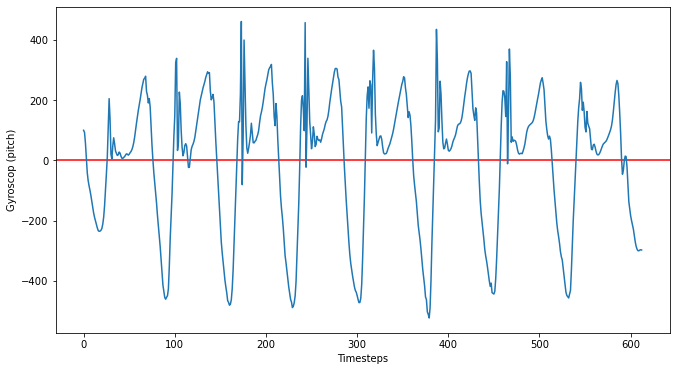

In [70]:
plt.figure(figsize=(11, 6))


plt.axhline(y=0, color='r', linestyle='-')

plt.plot(gyro_values*-1)
plt.xlabel('Timesteps')
plt.ylabel('Gyroscop (pitch)')


In [77]:
events = np.zeros_like(gyro_values)

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [75]:
all_data[all_data['Trial'] == 3]['Local Gyroscope - GEO Pitch']

17450    -99.84059
17451    -93.01799
17452    -58.33618
17453     -5.89916
17454     40.54603
           ...    
18058    299.90260
18059    300.22622
18060    297.92651
18061    296.70821
18062    297.68177
Name: Local Gyroscope - GEO Pitch, Length: 613, dtype: float64

In [332]:
n_samples=0
for p in all_data['Patient ID'].unique(): #loop over patients
    for i in all_data['Trial'].unique():
        d = all_data[(all_data['Patient ID'] == p) & (all_data['Trial'] == i)]
        if d.empty:
            print('DataFrame is empty!')
            print(f'Trail {i} does not exist in {p}')
        else:
            print(f'For patient: {p}, trial: {i}, there are: {len(d)} time-points')
            n_samples += 1

print(f'\nThere are {n_samples} samples')
        

For patient: AB3154 T6-10 BF, trial: 1, there are: 651 time-points
For patient: AB3154 T6-10 BF, trial: 2, there are: 541 time-points
For patient: AB3154 T6-10 BF, trial: 3, there are: 613 time-points
For patient: AB3154 T6-10 BF, trial: 4, there are: 601 time-points
For patient: AB3154 T6-10 BF, trial: 5, there are: 711 time-points
For patient: AB3154 T6-10 BF, trial: 6, there are: 651 time-points
For patient: AB3154 T6-10 BF, trial: 7, there are: 1031 time-points
For patient: AB3154 T6-10 BF, trial: 8, there are: 896 time-points
For patient: AB3154 T6-10 BF, trial: 9, there are: 812 time-points
DataFrame is empty!
Trail 10 does not exist in AB3154 T6-10 BF
For patient: AB5498 BF T6-10, trial: 1, there are: 831 time-points
For patient: AB5498 BF T6-10, trial: 2, there are: 714 time-points
For patient: AB5498 BF T6-10, trial: 3, there are: 736 time-points
For patient: AB5498 BF T6-10, trial: 4, there are: 701 time-points
For patient: AB5498 BF T6-10, trial: 5, there are: 586 time-point

In [333]:
all_data['Patient ID'] == "AB5498 BF T6-10" 

16100    False
16101    False
16102    False
16103    False
16104    False
         ...  
26147     True
26148     True
26149     True
26150     True
26151     True
Name: Patient ID, Length: 13518, dtype: bool

In [334]:
# os.makedirs('D:\Study 2 Data\Pre-process sample', exist_ok=True)  #check if directory exists
# all_data.to_csv('D:\Study 2 Data\Pre-process sample/exported-data3.csv')  #export data to csv

### Convert Data into numpy array for forming windows

In [335]:
m = all_data['Patient ID'].unique()

In [336]:
features, input_window, output_window, stride = set_settings()
print(f'features: {features}')
print(f'input window: {input_window}')
print(f'output window: {output_window}')
print(f'stride: {stride}')

features: ['Hips Flexion-Extension Left', 'Hips Abduction-Adduction Left', 'Hips Rotation Left', 'Knees Flexion-Extension Left', 'Knees Abduction-Adduction Left', 'Knees Rotation Left', 'Ankles Dorsiflexion-Plantarflexion Left', 'Ankles Eversion-Inversion Left', 'Ankles Rotation Left']
input window: 120
output window: 3
stride: 5


In [337]:
#create a numpy array that stores the data for export
sample_ID = []
# patients = 2
# n_trials = 10
# # samples = patients * n_trials
data_store = np.zeros((n_samples, 1500, 9), dtype=np.float32)
i = 0

for p in all_data['Patient ID'].unique(): #loop over patients 
    for t in all_data['Trial'].unique(): #loop over trials starting with trials 1 to trial 9 (inclusive)
        pd_array = all_data[(all_data['Patient ID'] == p) & (all_data['Trial'] == t)]
        if pd_array.empty:
            print('DataFrame is empty!')
            print(f'Trail {i} does not exist in {p}')
        else:
            np_array = pd_array.to_numpy()
            data_store[i, :np_array.shape[0], :] = np_array[:,3:] 
            sample_ID.append(p+ ' Ts'+str(t)) 
            i +=1



DataFrame is empty!
Trail 9 does not exist in AB3154 T6-10 BF


In [338]:
labels_keys = pd_array.columns[3:].tolist()

labels_idx = np.arange(0, len(labels_keys), 1)

labels = dict(zip(labels_keys, labels_idx))

len(labels)
labels

labels_keys

['Hips Flexion-Extension Left',
 'Hips Abduction-Adduction Left',
 'Hips Rotation Left',
 'Knees Flexion-Extension Left',
 'Knees Abduction-Adduction Left',
 'Knees Rotation Left',
 'Ankles Dorsiflexion-Plantarflexion Left',
 'Ankles Eversion-Inversion Left',
 'Ankles Rotation Left']

In [339]:
data_store.shape
data_store[3,:,:]

array([[33.0458 , -9.01975, -4.30109, ..., -4.23026,  2.69763, -0.42198],
       [34.44156, -8.8945 , -3.99353, ..., -3.98913,  2.9346 , -0.2081 ],
       [35.85006, -8.7532 , -3.89897, ..., -3.78138,  3.23843,  0.04619],
       ...,
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ]],
      dtype=float32)

In [340]:
# sequence = data_store[1,:,:]
# b_zeros = [] #array that stores the number of trailing zeros for each feacture 

# for f in features:
#     # trim the leading and training zeros
#     # f_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'f').shape[0]) #forward zeros
#     b_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'b').shape[0]) #backward zeros

# # max_f_zeros = max(f_zeros) #find the maximum number of leading zeros
# max_b_zeros = max(b_zeros) #find the maximum number of trailing/backward zeros 
# print(max_b_zeros)

# #total sequence length minus max leading and trailing zeros 
# trimmed_seqLen = sequence[:,0].shape[0] - (max_b_zeros)    
# print(trimmed_seqLen)

# # Slides are the number of times the input window can scan the sequence 
# # Using the equation that calculates the number of outputs as in convolution  (W – F + 2P) / S + 1, W=input image width, F=filter width, P=padding, S=stride
# # The width of the image is taken as the number of time steps in the sequence, corresponding to the length of any TRIMMED column in the data 
# slides = ((trimmed_seqLen - (input_window+output_window)) // stride) + 1
# print(f"number of slides is: {slides}")

# # Calculating the first index of each of the output sequences (first index always f_zeros as its always shifted to start with the first non-zero element)
# seq_indicies = (np.arange(slides) * stride)

# if slides <= 0:
#     raise ValueError("input window and output window length are greater than sequence length, check their values")

# # Creates an zero numpy array to store the samples in 
# X_values = np.zeros((len(seq_indicies) , input_window, len(features)))
# Y_values = np.zeros((len(seq_indicies), output_window, len(features)))

# # Loop through the features, then loop through the list of sequence indicies needed for input and output windows 
# for j, feature in enumerate(features):
#     # print(j)
#     # print(feature)
#     for i, idx in enumerate(seq_indicies):
#         X_values[i, :, j] = sequence[idx:idx+input_window, labels[feature]]
#         Y_values[i, :, j] = sequence[idx+input_window:idx+input_window + output_window, labels[feature]]
    

In [341]:
def window_generator(sequence, input_window, output_window, stride, features):
    """
    Trims the input sequence from leading and trailing zeros, then generates an array with input windows and another array for the corresponding output windows
    Args:
        sequence: (np.array, float32) columns are features while rows are time points
        features: (list, strin~g) column names
        input_window: (int)
        stride (int): the value the input window shifts along the sequence 
    Returns:

    """
    # shortest_seqLen = float('inf')

    # f_zeros = [] #array that stores the number of leading zeros for each feature
    b_zeros = [] #array that stores the number of trailing zeros for each feacture 

    for f in features:
        # trim the leading and training zeros
        # f_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'f').shape[0]) #forward zeros
        b_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'b').shape[0]) #backward zeros
    
    # max_f_zeros = max(f_zeros) #find the maximum number of leading zeros
    max_b_zeros = max(b_zeros) #find the maximum number of trailing/backward zeros 
    # print(max_b_zeros)

    #total sequence length minus max leading and trailing zeros 
    trimmed_seqLen = sequence[:,0].shape[0] - (max_b_zeros)    
    print(f'trimmed_seqLen: {trimmed_seqLen}')
    
    # Slides are the number of times the input window can scan the sequence 
    # Using the equation that calculates the number of outputs as in convolution  (W – F + 2P) / S + 1, W=input image width, F=filter width, P=padding, S=stride
    # The width of the image is taken as the number of time steps in the sequence, corresponding to the length of any TRIMMED column in the data 
    slides = ((trimmed_seqLen - (input_window+output_window)) // stride) + 1
    print(f"number of slides is: {slides}")

    # Calculating the first index of each of the output sequences (first index always f_zeros as its always shifted to start with the first non-zero element)
    seq_indicies = (np.arange(slides) * stride)

    if slides <= 0:
        raise ValueError("input window and output window length are greater than sequence length, check their values")

    # Creates an zero numpy array to store the samples in 
    X_values = np.zeros((len(seq_indicies) , input_window, len(features)))
    Y_values = np.zeros((len(seq_indicies), output_window, len(features)))

    # Loop through the features, then loop through the list of sequence indicies needed for input and output windows 
    for j, feature in enumerate(features):
        # print(j)
        # print(feature)
        for i, idx in enumerate(seq_indicies):
            X_values[i, :, j] = sequence[idx:idx+input_window, labels[feature]]
            Y_values[i, :, j] = sequence[idx+input_window:idx+input_window + output_window, labels[feature]]
    
    return X_values, Y_values 

In [342]:
# Creating training and validation datasets
# Selecting the features to be used when creating windows 

approx_seq_len = 2000 # appoximate the length of the longest sequence that can be encountered 
# samples_per_file = ((approx_seq_len - (input_window+output_window)) // stride) + 1 #number of window samples generated per file 
samples_per_file = 150
n_samples

# create a zero-filled 3D array with shape (number of samples * number of files, window size, number of features)

X_train_windows = np.zeros((samples_per_file*n_samples, input_window, len(features)), dtype=np.float32) #size can be reduced by decreasing train_size 
Y_train_windows = np.zeros((samples_per_file*n_samples, output_window, len(features)), dtype=np.float32) 


start_idx = 0 #setting start index to equal zero 
train_sample_sum = 0
train_excluded_samples = []
# Create training windows 

#for i in tqdm(range(train_size)): #Use for including all data including outliers 
for i in range(n_samples): 
       
    X_values, Y_values = window_generator(
        data_store[i,:,:],
        input_window=input_window, 
        output_window=output_window, 
        stride=stride, 
        features=features
        )

    end_idx = start_idx + X_values.shape[0]

    # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

    X_train_windows[start_idx:end_idx, :, :] = X_values
    Y_train_windows[start_idx:end_idx, :, :] = Y_values

    # print(f'number of samples copied: {X_train_data_store[start_idx:end_idx, :, :].shape[0]}')

    start_idx = end_idx 
    train_sample_sum += X_values.shape[0]

    # except Exception:
    #     exception_msg(i)
    #     train_excluded_samples.append(i)

# print(f"Completed storage of training windows samples, which contains {X_train_data_store.shape[0]} samples")
X_train_data = X_train_windows[:end_idx, :, :]
Y_train_data = Y_train_windows[:end_idx, :, :]


print(f'shape of X_train_windows: {X_train_windows.shape}')
print(f'shape of Y_train_windows: {Y_train_windows.shape}')

print(f'shape of X_train_data: {X_train_data.shape}')
print(f'shape of Y_train_data: {Y_train_data.shape}')

trimmed_seqLen: 651
number of slides is: 106
trimmed_seqLen: 541
number of slides is: 84
trimmed_seqLen: 613
number of slides is: 99
trimmed_seqLen: 601
number of slides is: 96
trimmed_seqLen: 711
number of slides is: 118
trimmed_seqLen: 651
number of slides is: 106
trimmed_seqLen: 1031
number of slides is: 182
trimmed_seqLen: 896
number of slides is: 155
trimmed_seqLen: 812
number of slides is: 138
trimmed_seqLen: 831
number of slides is: 142
trimmed_seqLen: 714
number of slides is: 119
trimmed_seqLen: 736
number of slides is: 123
trimmed_seqLen: 701
number of slides is: 116
trimmed_seqLen: 586
number of slides is: 93
trimmed_seqLen: 666
number of slides is: 109
trimmed_seqLen: 672
number of slides is: 110
trimmed_seqLen: 691
number of slides is: 114
trimmed_seqLen: 692
number of slides is: 114
trimmed_seqLen: 722
number of slides is: 120
shape of X_train_windows: (2850, 120, 9)
shape of Y_train_windows: (2850, 3, 9)
shape of X_train_data: (2244, 120, 9)
shape of Y_train_data: (2244, 

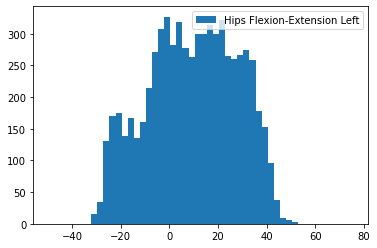

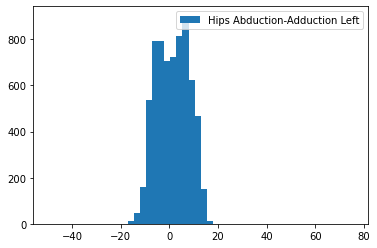

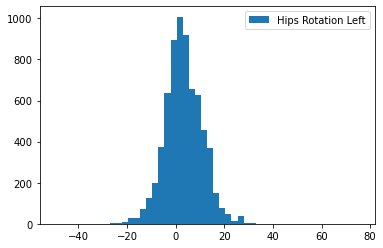

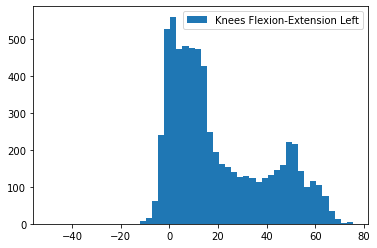

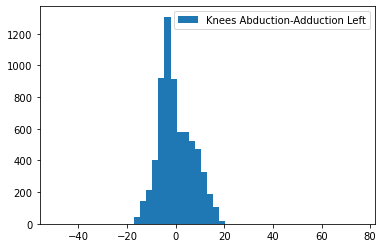

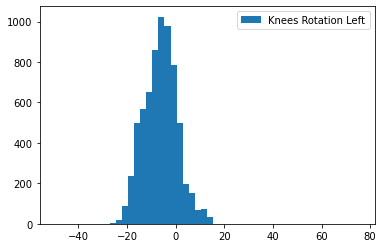

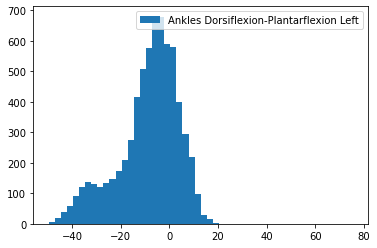

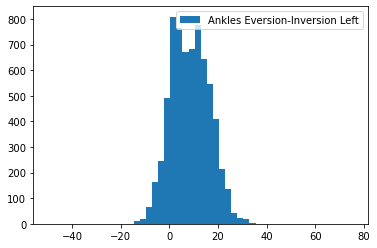

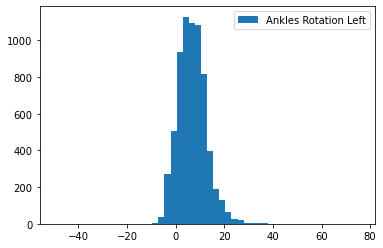

In [343]:
# Plot histogram of the data 
for f in range(len(features)):
    plt.hist(Y_train_data[:,:,f].reshape(-1,1), label = features[f], bins=50, range=(Y_train_data.min(), Y_train_data.max()))
    plt.legend()
    plt.show()

In [344]:
def normalise_fit(data):
    '''
    Normalises X_train and output scales to use for normalising testing data and de-normalising output
    Args:
        prenormalised_data should be a 3-dimensional np.array 
    
    Output:
        normalised_data: np.array with the same shape as input data, but normalised
        scaling_factors: np.array with 2 rows index 0 for min_val, index 1 for max_value and nfeatures columns 

    '''
    
    if data.ndim != 3:
        raise ValueError("this function can only normalise 3-dimensional inputs")

    normalised_data = np.zeros(data.shape, dtype=np.float32) 

    features = data.shape[-1]
    scaling_factors = np.zeros((2, features))

    for feature in range(features):
        # print(feature)
        scaling_factors[0, feature], scaling_factors[1, feature] =  data[:,:,feature].min(), data[:,:,feature].max() #index 0 is for min, index 1 for max (applies to all features)
        normalised_data[:,:,feature] = (data[:,:,feature] - data[:,:,feature].min())/ (data[:,:,feature].max() - data[:,:,feature].min())

        # scaling_factors[0, feature], scaling_factors[1, feature] =  -90, 90 #index 0 is for min, index 1 for max (applies to all features)
        # normalised_data[:,:,feature] = (data[:,:,feature] - (-90))/ ((90) - (-90))

    return normalised_data, scaling_factors

In [345]:
def normalise_transform(data, scaling_factors):
    '''
    Normalise data based on the scaling factors used to normalised the training data 
    '''

    transformed_data = np.zeros(data.shape, dtype=np.float32)
    if data.shape[-1] > 1:
        for feature in range(data.shape[-1]): #loop over the number of features
            min_val = scaling_factors[0, feature] #get minimum value
            # print(f'min_val = {min_val}')
            max_val = scaling_factors[1, feature] # get maximum value 
            # print(f'max_val = {max_val}')

            transformed_data[:,:,feature] = (data[:,:,feature] - min_val) / (max_val - min_val)
    
    # in case there is one feature only where scaling_factor shape (2,1)
    else:
        min_val = scaling_factors[0]
        max_val = scaling_factors[1]
        transformed_data[:,:,0] = (data[:,:,0] - min_val) / (max_val - min_val)
    
    return transformed_data

In [346]:
# denorm_value = ((max-min) * norm_value) + min
def denormalise(data, scaling_factors):
    '''
    De-normalise data of the model
    '''
    denormalised_data = np.zeros(data.shape,  dtype=np.float32)

    for feature in range(data.shape[-1]):
        min_val = scaling_factors[0, feature]
        max_val = scaling_factors[1, feature]

        denormalised_data[:,:,feature] = ((max_val - min_val) * data[:,:,feature]) + min_val
    
    return denormalised_data

In [347]:
X_train_norm, scalars = normalise_fit(X_train_data)
# X_train_data = 1
Y_train_norm = normalise_transform(Y_train_data, scalars)
# Y_train_data = 1

X_train_data.shape

(2244, 120, 9)

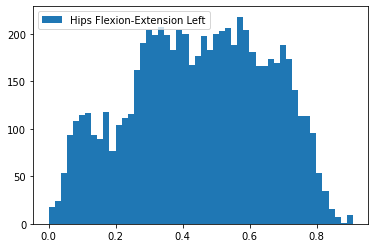

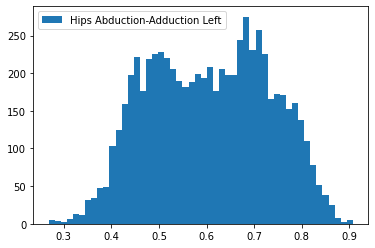

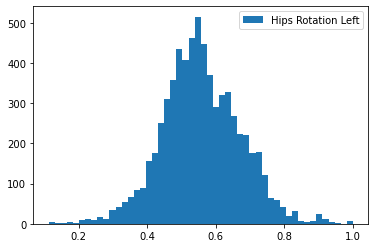

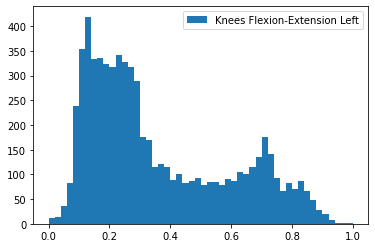

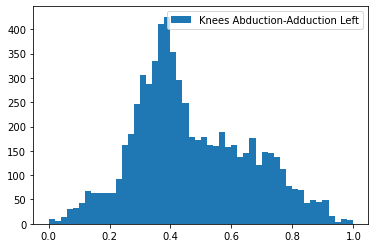

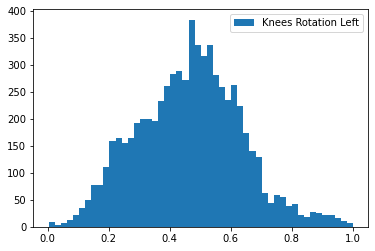

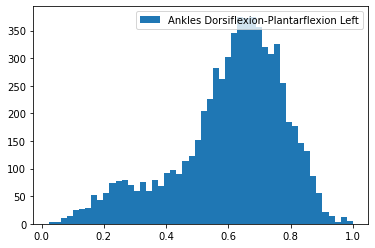

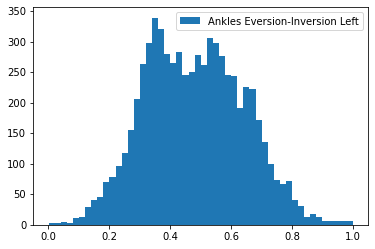

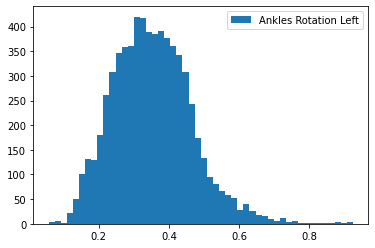

In [348]:
# Plot histogram of the data 
for f in range(len(features)):
    plt.hist(Y_train_norm[:,:,f].reshape(-1,1), bins=50, label = features[f])
    plt.legend()
    plt.show()

In [349]:
# # useful resources: https://www.youtube.com/watch?v=8A6TEjG2DNw (LSTM Time Series Prediction Tutorial using PyTorch in Python | Coronavirus Daily Cases Forecasting)
# LSTM model 
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, in_seq_len, out_seq_len, output_size, device):
        super(LSTM, self).__init__()
        '''
        nn.lstm: 
        input_size = number of features in input, if batch_first = TRUE (batchSize, seq_len, Hin) FEATURES
        hidden_size = number of features in hidden state
        num_layers
        batch_first = if TRUE (batch, seq, Hin) Hin may mean input features
        h_0 = (D * num_layers, batchSize, Hout)
        c_0 = (D * num_layers, batchSize, Hcell)

        output = (batchSize, seq_len, D * Hout) Hout may mean output features, if batch first = TRUE 
        h_0 = (D*num_layers, N, Hout) final state for each element in the batch 
        C_0 = (D*num_layers, N, Hcell) final cell state for each element 

        nn.linear:
        input_size = (N,*, Hin) Hin = input_features (equal to hidden size therefore is arbitrarily set)
        output_size = (N, *, Hout) Hout = output features (equal to output_size passed in to the model) 

        '''
        # Pytorch documentation: 
        # >>> rnn = nn.LSTM(10, 20, 2) features, hidden_size, number of layers 
        # >>> input = torch.randn(5, 3, 10) in_seq_len, batch_size, hidden_size (batch size should not be input to the mode, inferred from the shape of the input and will be the first number if batch_first = TRUE)
        # >>> h0 = torch.randn(2, 3, 20)
        # >>> c0 = torch.randn(2, 3, 20)
        # >>> output, (hn, cn) = rnn(input, (h0, c0))

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.in_seq_len = in_seq_len
        self.output_size = output_size
        self.out_seq_len = out_seq_len
        self.device = device
        
        # nn.LSTM(features, hidden_size, number of layers)
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first = True)

        #nn.fc1
        self.fc1 = nn.Linear(in_features=self.hidden_size, out_features=(self.output_size * self.out_seq_len))

    def forward(self, input_data):

        # initialise hidden and cell states after passing through each batch (this is skipped in stateless model)
        h_0 = torch.zeros(self.num_layers, input_data.shape[0], self.hidden_size).to(self.device) # input_data.shape[0] is equal to batch size
        c_0 = torch.zeros(self.num_layers, input_data.shape[0], self.hidden_size).to(self.device)

        #propagate through LSTM
        lstm_out, (h_out, c_out) = self.lstm(input_data, (h_0, c_0))
        # lsmt_out.shape = (batch_size,seq_length, hidden_size)
        # print(f'lsmt_out: {lstm_out.shape}')
        # print(f'h_out: {h_out[-1].shape}')

        # propagate through linear layer 
        fc1_out = self.fc1(h_out[-1])
        # print(f'preds.shape (before reshaping): {fc1_out.shape}')
        
        preds = fc1_out.reshape(input_data.shape[0], self.out_seq_len, self.output_size)
        # print(f'preds.shape (after reshaping): {preds.shape}')
        
        return preds

In [350]:
import_path = r'D:\Study 1 Results and Models\Study 1 Models\LSTM_4' + '\\' + 'Exp014-2022-02-10-LSTM-In120-Out3.pickle'
# # # import_path = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Models\CNN_1' + '\\' + 'Exp001-2022-01-24-CNN-In96-Out1.pickle'
# # # model_CNN = CNN(input_size, output_size=output_size, kernel_size=kernel_size, stride=1, in_seq_len=in_seq_len, out_seq_len=out_seq_len,  device = DEVICE).to(DEVICE)

input_size=len(features)
hidden_size=128
num_layers=4
in_seq_len=input_window
out_seq_len=output_window
output_size=len(features)
# num_epochs=60

# # learning_rate= 0.001

model_LSTM = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, in_seq_len=in_seq_len, out_seq_len=out_seq_len, output_size=output_size, device=DEVICE).to(DEVICE)
model_LSTM.load_state_dict(torch.load(import_path))
model_LSTM.eval()

LSTM(
  (lstm): LSTM(9, 128, num_layers=4, batch_first=True)
  (fc1): Linear(in_features=128, out_features=27, bias=True)
)

In [351]:
# for p in model_LSTM.parameters():
#     print(p.device)

In [352]:
# Testing function 
def test_LSTM(model, dataloader):
    loss_function = nn.MSELoss(reduction='mean')
    model.eval()
    actual_output, pred_output = [], []
    running_loss = 0. 
    
    with torch.no_grad():
        for idx, (batch_inputs, batch_targets) in tqdm(enumerate(dataloader)):

            batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)

            # if idx==0:
            #     batch_preds = model(batch_inputs)
            #     # print(f'batch shape: {batch_preds.shape}')
            #     loss = loss_function(batch_preds, batch_targets)
            #     running_loss += loss.item()
            #     current_preds = batch_preds
            #     all_preds = batch_preds

            # else:
            #     batch_preds = model(batch_inputs)
            #     print(f'batch shape: {batch_preds.shape}')
            #     loss = loss_function(batch_preds, batch_targets)
            #     running_loss += loss.item()
            #     all_preds = torch.cat((current_preds, batch_preds), dim=0)
            #     current_preds = batch_preds

            batch_preds = model(batch_inputs)
            # print(f'batch preds: {batch_preds.type}')
            loss = loss_function(batch_preds, batch_targets)
            running_loss += loss.item()
            actual_output.append(batch_targets)
            pred_output.append(batch_preds)


            #             lst = []
            # print(f'{x.size()}')
            # for i in range(10):
            #     x += i  # say we do something with x at iteration i
            #     lst.append(x)
            # # lstt = torch.stack([x for _ in range(10)])
            # lstt = torch.stack(lst)
            # print(lstt.size())

        total_loss = running_loss / len(dataloader)

        actual_output_tensor = torch.vstack(actual_output)
        pred_output_tensor = torch.vstack(pred_output)
    
    return pred_output_tensor, actual_output_tensor, total_loss

In [353]:
# Creates dataset object that gets individual samples for training/testing so that the Dataloader can generate batches
class gaitDataset(Dataset):
    def __init__(self, x, y):
        self.x = x 
        self.y = y 

    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, index):
        X_sample = self.x[index, :, :]
        Y_sample = self.y[index, :, :]
        return X_sample, Y_sample

In [354]:
# X_test_norm = normalise_transform(X_test_data, scalars)
# Y_test_norm = normalise_transform(Y_test_data, scalars)

# Convert to Tensor 
# do not store on GPU (yet)
X_test = torch.from_numpy(X_train_norm).float()
Y_test = torch.from_numpy(Y_train_norm).float()

print(f'X_test shape: {X_test.shape}')
print(f'Y_test shape: {Y_test.shape}')

X_test shape: torch.Size([2244, 120, 9])
Y_test shape: torch.Size([2244, 3, 9])


In [355]:
test_dataset = gaitDataset(X_test, Y_test)
# # test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False) #ADJUSTED

print(f"Test Dataset length: {len(test_dataset)}")

Test Dataset length: 2244


In [356]:
pred_test_output, actual_test_output, test_loss = test_LSTM(model_LSTM, test_dataloader)

predicted_values_test = pred_test_output.cpu().numpy() # premute again to make the order of the array (samples, windows, features)
actual_values_test =  actual_test_output.cpu().numpy()

print(f'test loss: {test_loss}')

print(f'Shape of predicted values test: {predicted_values_test.shape}')
print(f'shape of actual values test: {actual_values_test.shape}')

predicted_test_denorm = denormalise(predicted_values_test, scalars)
actual_test_denorm =  denormalise(actual_values_test, scalars)

print(f'Shape of predicted values test post denormalisation: {predicted_test_denorm.shape}')
print(f'shape of actual values test post denormalisation: {actual_test_denorm.shape}')

0it [00:00, ?it/s]

test loss: 5.117340193259813e-05
Shape of predicted values test: (2244, 3, 9)
shape of actual values test: (2244, 3, 9)
Shape of predicted values test post denormalisation: (2244, 3, 9)
shape of actual values test post denormalisation: (2244, 3, 9)


In [357]:
def mse_loss(preds, targets, reduction = 'mean', format='torch'):

    
    if format == 'torch': #default option
        loss = 1/(preds.shape[0]*preds.shape[1]*preds.shape[2]) * torch.sum((targets - preds) ** 2)
        # print(f'divide shape: {preds.shape[0]*preds.shape[1]*preds.shape[2]}')
        # print(f'square sum: {torch.sum((targets - preds) ** 2)}')

        # std = torch.sqrt(torch.sum((((targets - preds) ** 2) - loss)**2) * (1/preds.shape[0]*preds.shape[1]*preds.shape[2]-1))
        std = torch.std()
        
        if reduction == 'sum':
            loss = torch.sum((targets - preds) ** 2)
    
    if format == 'np':
        loss = 1/(preds.shape[0]*preds.shape[1]*preds.shape[2]) * np.sum((targets - preds) ** 2)
        # print(f'divide shape: {preds.shape[0]*preds.shape[1]*preds.shape[2]}')
        # print(f'square sum: {torch.sum((targets - preds) ** 2)}')

        std = np.std(((targets - preds) ** 2).reshape(-1,1).squeeze())
        # print(np.sqrt(np.sum(((targets - preds) ** 2) - loss)**2))
        
        if reduction == 'sum':
            loss = np.sum((targets - preds) ** 2)

    return loss, std

In [358]:
#mae 
def mae_loss(preds, targets, reduction = 'mean', format='torch'):

    if format == 'torch': #default option
        loss = 1/(preds.shape[0]*preds.shape[1]*preds.shape[2]) * torch.sum(torch.abs(targets - preds))
        # print(f'divide shape: {preds.shape[0]*preds.shape[1]*preds.shape[2]}')
        # print(f'square sum: {torch.sum((targets - preds) ** 2)}')
        
        if reduction == 'sum':
            loss = torch.sum(torch.abs(targets - preds))
    
    if format == 'np':
        loss = 1/(preds.shape[0]*preds.shape[1]*preds.shape[2]) * np.sum(np.absolute(targets - preds))
        # print(f'divide shape: {preds.shape[0]*preds.shape[1]*preds.shape[2]}')
        # print(f'square sum: {torch.sum((targets - preds) ** 2)}')
        
        std = np.std(np.abs(targets - preds).reshape(-1,1).squeeze())

        if reduction == 'sum':
            loss = np.sum(np.absolute(targets - preds))

    return loss, std

In [359]:
test_mse_loss, test_mse_std = mse_loss(predicted_test_denorm, actual_test_denorm, reduction='mean', format='np')
test_mae_loss, test_mae_std = mae_loss(predicted_test_denorm, actual_test_denorm, reduction='mean', format='np')

print(f'Test MSE Loss: {test_mse_loss}')
print(f'Test MSE std: {test_mse_std} ')

# MDE= mae_loss(actual_test_denorm[:-1,:,:],actual_test_denorm[1:,:,:],reduction='mean', format='np')
MDE= mae_loss(actual_test_denorm[:,:,:],actual_test_denorm[:,:,:],reduction='mean', format='np')

print(f'Test MAE Loss: {test_mae_loss}')
print(f'Test MAE std: {test_mae_std}')

Test MSE Loss: 0.184159252992548
Test MSE std: 0.5816987156867981 
Test MAE Loss: 0.2889795241013072
Test MAE std: 0.3172539472579956


(array([5.815e+03, 6.730e+02, 1.430e+02, 5.200e+01, 2.900e+01, 1.300e+01,
        3.000e+00, 1.000e+00, 1.000e+00, 2.000e+00]),
 array([1.9073486e-06, 3.5805780e-01, 7.1611369e-01, 1.0741695e+00,
        1.4322255e+00, 1.7902813e+00, 2.1483371e+00, 2.5063930e+00,
        2.8644490e+00, 3.2225049e+00, 3.5805607e+00], dtype=float32),
 <BarContainer object of 10 artists>)

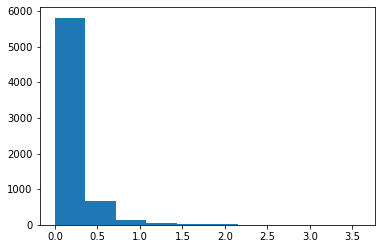

In [392]:
plt.hist(np.abs(predicted_test_denorm[:,:,1].reshape(-1,1) - actual_test_denorm[:,:,1].reshape(-1,1)))

